In [6]:
using Pkg, Revise, BenchmarkTools
Pkg.activate(ENV["JULIA_DQMC"])
include(joinpath(ENV["JULIA_DQMC"], "src/dqmc_framework.jl"))

# includet(joinpath(ENV["JULIA_DQMC"], "src/fermion_measurements.jl")) # explicitly track fermion_measurements.jl
# includet(joinpath(ENV["JULIA_DQMC"], "src/tdgf_svd.jl")) # explicitly track new tdgf_svd.jl
# includet(joinpath(ENV["JULIA_DQMC"], "src/linalg.jl"))


function load_mc(input)
    p = Params()
    p.output_file = "live.out.h5.running"
    xml2parameters!(p, input)
    p.safe_mult = 1 # manually overwriting safe_mult
    # p.beta = 20
    # p.slices = 200
    mc = DQMC(p)
    init!(mc)
    mc
end

┌ Info: Recompiling stale cache file C:\Users\carsten\.julia\compiled\v1.1\MonteCarloObservable\FUHqM.ji for MonteCarloObservable [8a675f2c-1eea-59ef-99a5-5eebc71d1519]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file C:\Users\carsten\.julia\compiled\v1.1\FFTW\PvIn2.ji for FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file C:\Users\carsten\.julia\compiled\v1.1\DSP\OtML7.ji for DSP [717857b8-e6f2-59f4-9121-6e50c889abd2]
└ @ Base loading.jl:1184


load_mc (generic function with 1 method)

# First, $\beta = 8$

In [8]:
mc = load_mc("dqmc.in.xml") # noninteracting_small_bestpossible_B_8
@assert mc.p.safe_mult == 1
@assert mc.p.beta == 8
@assert mc.p.L == 2
@assert !mc.p.chkr
@assert !mc.p.Bfield

L = 2
SLICES = 80
DELTA_TAU = 0.1
THERMALIZATION = 100
MEASUREMENTS = 100
SAFE_MULT = 1
CHECKERBOARD = FALSE
HOPPINGS = 1.0,0.5,-0.5,-1.0
MU = -0.5
LAMBDA = 0.0
U = 0.0
R = 1.0
C = 0.0
GLOBAL_UPDATES = TRUE
GLOBAL_RATE = 5
BFIELD = FALSE
WRITE_EVERY_NTH = 10
OPDIM = 1

CB = CBFalse
p.hoppings = "1.0,0.5,-0.5,-1.0"
p.Nhoppings = "none"
p.NNhoppings = "none"
p.lattice_file = "C:/Users/carsten/Desktop/sciebo/lattices/square_L_2_W_2.xml"


Loading lattice with 4 sites
Initializing neighbor-tables
Initializing hopping exponentials

Initializing HS field
Initializing boson action

Building stack
Initial propagate: 81 -1


In [9]:
gudt = calc_greens(mc);
@assert isapprox(gudt, mc.s.greens)

gudv = calc_greens_udv_simple(mc);

ged = h5read("greens-ed-free-beta-8.jld", "greens")[1:8,1:8];

HDF5-DIAG: Error detected in HDF5 (1.8.13) thread 0:
  #000: /home/abuild/rpmbuild/BUILD/hdf5-1.8.13/src/H5F.c line 861 in H5Fis_hdf5(): unable to open file
    major: Low-level I/O
    minor: Unable to initialize object
  #001: /home/abuild/rpmbuild/BUILD/hdf5-1.8.13/src/H5FD.c line 985 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #002: /home/abuild/rpmbuild/BUILD/hdf5-1.8.13/src/H5FDsec2.c line 343 in H5FD_sec2_open(): unable to open file: name = 'greens-ed-free-beta-8.jld', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0
    major: File accessibilty
    minor: Unable to open file


ErrorException: Cannot access file greens-ed-free-beta-8.jld

#### QR vs ED

In [4]:
compare(gudt, ged) # WHY DONT THEY AGREE BETTER? Answer: ED only considers finite number of low lying states

max absdiff: 1.7e-07
mean absdiff: 5.0e-08
max reldiff: 2.0e+00
mean reldiff: 1.0e+00
effective max reldiff: 2.0e+00
effective mean reldiff: 1.0e+00


false

#### SVD vs ED

In [5]:
compare(gudv, ged)

max absdiff: 1.7e-07
mean absdiff: 5.0e-08
max reldiff: 2.0e+00
mean reldiff: 1.0e+00
effective max reldiff: 2.0e+00
effective mean reldiff: 1.0e+00


false

#### QR vs SVD

In [6]:
compare(gudt, gudv)

max absdiff: 2.8e-11
mean absdiff: 7.3e-12
max reldiff: 2.0e+00
mean reldiff: 1.0e+00
effective max reldiff: 2.0e+00
effective mean reldiff: 1.0e+00


true

**We see that up to the precision of the ED, we find good agreement between the stabilization techniques.**

We can also compare `Budv` and `Budt`,

In [7]:
Budv = calc_Bchain_udv(mc, 1, mc.p.slices);
Budt = calc_Bchain(mc, 1, mc.p.slices);

Mudv = UDV_to_mat(Budv[1:3]...)
Mudt = UDT_to_mat(Budt[1:3]...)

@show isapprox(Mudv, Mudt)

display(isapprox.(Mudt, Mudv))

absdiff(Mudv, Mudt)

8×8 BitArray{2}:
  true   true   true   true  false  false  false  false
  true   true   true   true  false  false  false  false
  true   true   true   true  false  false  false  false
  true   true   true   true  false  false  false  false
 false  false  false  false   true   true   true   true
 false  false  false  false   true   true   true   true
 false  false  false  false   true   true   true   true
 false  false  false  false   true   true   true   true

isapprox(Mudv, Mudt) = true


8×8 Array{Float64,2}:
 8.9407e-8   4.47035e-8  5.96046e-8  …  1.13151e-8  1.08071e-8  6.27124e-9
 7.45058e-8  1.49012e-8  7.45058e-8     1.91214e-8  9.08231e-9  1.3618e-8 
 1.3411e-7   1.04308e-7  1.49012e-8     9.95549e-9  8.6339e-9   4.09802e-9
 1.19209e-7  5.96046e-8  2.98023e-8     4.64913e-9  2.8547e-9   1.68102e-9
 1.55769e-6  1.57237e-6  1.62511e-6     1.93715e-7  6.25849e-7  5.51343e-7
 1.55766e-6  1.57234e-6  1.62508e-6  …  2.23517e-7  6.10948e-7  5.36442e-7
 1.5789e-6   1.59357e-6  1.64632e-6     1.93715e-7  6.55651e-7  5.81145e-7
 1.57877e-6  1.59345e-6  1.64619e-6     2.23517e-7  6.25849e-7  5.51343e-7

In [8]:
Mudv

8×8 Array{Float64,2}:
  1.21291e8    1.21291e8    1.21291e8   …   7.50377e-9   -7.5037e-9  
  1.21291e8    1.21291e8    1.21291e8      -1.23857e-8    1.23856e-8 
  1.21291e8    1.21291e8    1.21291e8       5.33055e-9   -5.33047e-9 
  1.21291e8    1.21291e8    1.21291e8      -4.48658e-10   4.48581e-10
 -1.55879e-6   1.54311e-6  -1.62511e-6     -1.21291e8     1.21291e8  
  1.55876e-6  -1.54308e-6   1.62508e-6  …   1.21291e8    -1.21291e8  
  1.58e-6     -1.56432e-6   1.64632e-6      1.21291e8    -1.21291e8  
 -1.57987e-6   1.56419e-6  -1.64619e-6     -1.21291e8     1.21291e8  

and there singular values:

┌ Info: Recompiling stale cache file C:\Users\carsten\.julia\compiled\v1.1\PyPlot\oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


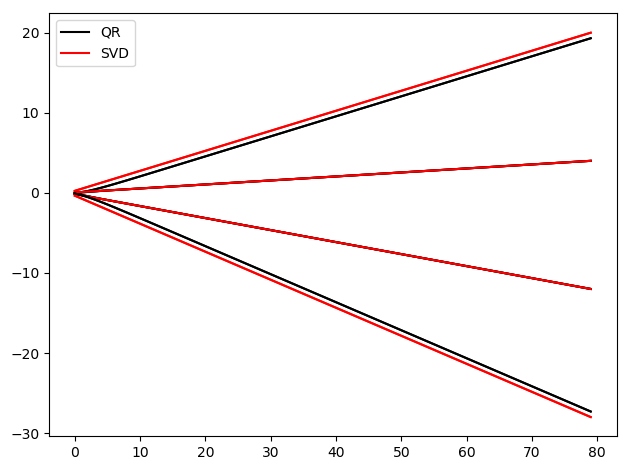

In [9]:
using PyPlot

function plot_svs_comparison(Budt, Budv)
    svs_udv = Budv[4]
    svs_udt = Budt[4]

    which_svs = 1:size(svs_udv,1)

    figure()
    @views for k in which_svs
        plot(svs_udt[k,:], label=(k == 1 ? "QR" : ""), c="k")
        plot(svs_udv[k,:], label=(k == 1 ? "SVD" : ""), c="r")
    end
    legend()
    tight_layout()
end

plot_svs_comparison(Budt, Budv)

# Now, let's look at the same system (settings) for $\beta = 40$

In [11]:
mc = load_mc("dqmc.in.xml") # noninteracting_small_bestpossible_B_8
@assert mc.p.safe_mult == 1
@assert mc.p.beta == 40
@assert mc.p.L == 2
@assert !mc.p.chkr
@assert !mc.p.Bfield

L = 2
SLICES = 400
DELTA_TAU = 0.1
THERMALIZATION = 100
MEASUREMENTS = 100
SAFE_MULT = 1
CHECKERBOARD = FALSE
HOPPINGS = 1.0,0.5,-0.5,-1.0
MU = -0.5
LAMBDA = 0.0
U = 0.0
R = 1.0
C = 0.0
GLOBAL_UPDATES = TRUE
GLOBAL_RATE = 5
BFIELD = FALSE
WRITE_EVERY_NTH = 10
OPDIM = 1

CB = CBFalse
p.hoppings = "1.0,0.5,-0.5,-1.0"
p.Nhoppings = "none"
p.NNhoppings = "none"
p.lattice_file = "C:/Users/carsten/Desktop/sciebo/lattices/square_L_2_W_2.xml"


Loading lattice with 4 sites
Initializing neighbor-tables
Initializing hopping exponentials

Initializing HS field
Initializing boson action

Building stack
Initial propagate: 401 -1


In [12]:
gudt = calc_greens(mc);
@assert isapprox(gudt, mc.s.greens)

gudv = calc_greens_udv_simple(mc);

ged = h5read("greens-ed-free-beta-40.jld", "greens")[1:8,1:8];

HDF5-DIAG: Error detected in HDF5 (1.8.13) thread 0:
  #000: /home/abuild/rpmbuild/BUILD/hdf5-1.8.13/src/H5F.c line 861 in H5Fis_hdf5(): unable to open file
    major: Low-level I/O
    minor: Unable to initialize object
  #001: /home/abuild/rpmbuild/BUILD/hdf5-1.8.13/src/H5FD.c line 985 in H5FD_open(): open failed
    major: Virtual File Layer
    minor: Unable to initialize object
  #002: /home/abuild/rpmbuild/BUILD/hdf5-1.8.13/src/H5FDsec2.c line 343 in H5FD_sec2_open(): unable to open file: name = 'greens-ed-free-beta-40.jld', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0
    major: File accessibilty
    minor: Unable to open file


ErrorException: Cannot access file greens-ed-free-beta-40.jld

#### QR vs ED

In [12]:
compare(gudt, ged) # Now they agree better, because at lower T only low lying states (captured by ED) matter

max absdiff: 1.4e-15
mean absdiff: 3.2e-16
max reldiff: 2.0e+00
mean reldiff: 1.0e+00
effective max reldiff: 0.0e+00
effective mean reldiff: 0.0e+00


true

#### SVD vs ED

In [13]:
compare(gudv, ged)

max absdiff: 8.6e-01
mean absdiff: 3.1e-01
max reldiff: 6.0e+00
mean reldiff: 1.9e+00
effective max reldiff: 6.0e+00
effective mean reldiff: 1.9e+00


false

#### QR vs SVD

In [14]:
compare(gudt, gudv)

max absdiff: 8.6e-01
mean absdiff: 3.1e-01
max reldiff: 6.0e+00
mean reldiff: 1.9e+00
effective max reldiff: 6.0e+00
effective mean reldiff: 1.9e+00


false

**At lower T, QR seems to work fine but SVD doesn't! Why?**

Comparing `Budt` and `Budv` directly,

In [54]:
using JacobiSVD # experimental package
decompose_udv!(A::AbstractMatrix{<:Number}) = JacobiSVD.gesvj!('G','U','V', A) # was gesdd! at some point

decompose_udv!(A::AbstractMatrix{<:Number}) = LinearAlgebra.LAPACK.gesvd!('A','A',A) # was gesdd! at some point

decompose_udv! (generic function with 1 method)

In [61]:
using PyCall
# @pyimport numpy as np
@pyimport scipy.linalg as splinalg

decompose_udv!(A::AbstractMatrix{<:Number}) = splinalg.svd(A, lapack_driver="gesvd") # np.linalg[:svd](A)

decompose_udv! (generic function with 1 method)

In [17]:
Budv = calc_Bchain_udv(mc, 1, mc.p.slices, 1);
Budt = calc_Bchain(mc, 1, mc.p.slices, 1);

Mudv = UDV_to_mat(Budv[1:3]...)
Mudt = UDT_to_mat(Budt[1:3]...)

@show isapprox(Mudv, Mudt)

display(isapprox.(Mudt, Mudv))

absdiff(Mudv, Mudt)

8×8 BitArray{2}:
  true   true   true   true  false  false  false  false
  true   true   true   true  false  false  false  false
  true   true   true   true  false  false  false  false
  true   true   true   true  false  false  false  false
 false  false  false  false   true   true   true   true
 false  false  false  false   true   true   true   true
 false  false  false  false   true   true   true   true
 false  false  false  false   true   true   true   true

isapprox(Mudv, Mudt) = true


┌ Warning: UDT_to_mat! probably shouldn't be called here
└ @ Main C:\Users\carsten\Desktop\sciebo\codes\julia-sdw-dqmc\src\linalg.jl:607


8×8 Array{Float64,2}:
 4.70417e28  4.33279e28  3.71382e28  …  2.49423e27  2.71671e27  2.46667e27
 4.209e28    3.83761e28  3.21864e28     2.49129e27  2.29024e27  2.54592e27
 4.33279e28  3.96141e28  3.34244e28     3.53649e26  5.99749e26  3.55924e26
 4.33279e28  3.96141e28  3.34244e28     4.951e26    2.94116e26  5.49814e26
 1.48806e29  1.54426e29  1.57349e29     1.25032e29  1.10177e29  1.12653e29
 1.48806e29  1.54426e29  1.57349e29  …  1.21318e29  1.06463e29  1.08939e29
 1.48806e29  1.54426e29  1.57349e29     1.25032e29  1.10177e29  1.12653e29
 1.48806e29  1.54426e29  1.57349e29     1.25032e29  1.10177e29  1.12653e29

In [63]:
Mudv

8×8 Array{Float64,2}:
  6.72029e42   6.72029e42   6.72029e42  …   2.53368e27  -2.53495e27
  6.72029e42   6.72029e42   6.72029e42     -2.47326e27   2.47763e27
  6.72029e42   6.72029e42   6.72029e42      4.16723e26  -4.24209e26
  6.72029e42   6.72029e42   6.72029e42     -4.77142e26   4.81529e26
 -1.48866e29   1.52805e29  -1.57349e29     -6.72029e42   6.72029e42
  1.48866e29  -1.52805e29   1.57349e29  …   6.72029e42  -6.72029e42
  1.48866e29  -1.52805e29   1.57349e29      6.72029e42  -6.72029e42
 -1.48866e29   1.52805e29  -1.57349e29     -6.72029e42   6.72029e42

In [64]:
Mudt

8×8 Array{Float64,2}:
  6.72029e42   6.72029e42  6.72029e42  …  -1.83026e26  -6.82852e25
  6.72029e42   6.72029e42  6.72029e42     -1.83026e26  -6.82852e25
  6.72029e42   6.72029e42  6.72029e42     -1.83026e26  -6.82852e25
  6.72029e42   6.72029e42  6.72029e42     -1.83026e26  -6.82852e25
 -6.08247e25  -1.62103e27  0.0            -6.72029e42   6.72029e42
  6.08247e25   1.62103e27  0.0         …   6.72029e42  -6.72029e42
  6.08247e25   1.62103e27  0.0             6.72029e42  -6.72029e42
 -6.08247e25  -1.62103e27  0.0            -6.72029e42   6.72029e42

#### Inspecting the singular values

In [65]:
Budt[2]

8-element Array{Float64,1}:
 1.344058570908608e43 
 1.3440585709079413e43
 4.851651954098959e8  
 4.851651954098575e8  
 8.75651076269526e-27 
 8.756510762695154e-27
 3.160840120548144e-61
 3.16084012054782e-61 

In [66]:
Budv[2]

8-element Array{Float64,1}:
  2.6881171418172126e43
  2.688117141815916e43 
  6.2272525036778785e25
  2.0472746004124313e20
  8.614642768629248e16 
 -0.0                  
 -0.0                  
  0.0                  

In [21]:
Budv[4]

8×400 Array{Float64,2}:
  0.25   0.5   0.75   1.0   1.25   1.5  …    99.5       99.75     100.0   
  0.25   0.5   0.75   1.0   1.25   1.5       99.5       99.75     100.0   
  0.05   0.1   0.15   0.2   0.25   0.3       60.4131    60.3168    59.3936
  0.05   0.1   0.15   0.2   0.25   0.3       47.0493    47.0369    46.7682
 -0.15  -0.3  -0.45  -0.6  -0.75  -0.9       37.9535    37.8918    38.9948
 -0.15  -0.3  -0.45  -0.6  -0.75  -0.9  …  -Inf       -Inf       -Inf     
 -0.35  -0.7  -1.05  -1.4  -1.75  -2.1     -Inf       -Inf       -Inf     
 -0.35  -0.7  -1.05  -1.4  -1.75  -2.1     -Inf       -Inf       -Inf     

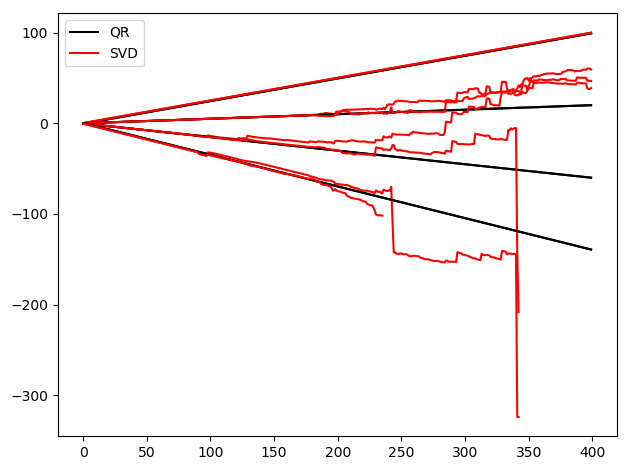

In [22]:
using PyPlot

function plot_svs_comparison(Budt, Budv)
    svs_udv = Budv[4]
    svs_udt = Budt[4]

    which_svs = 1:size(svs_udv,1)

    figure()
    @views for k in which_svs
        plot(svs_udt[k,:], label=(k == 1 ? "QR" : ""), c="k")
        plot(svs_udv[k,:], label=(k == 1 ? "SVD" : ""), c="r")
    end
    legend()
    tight_layout()
end

plot_svs_comparison(Budt, Budv)

# Try to extract MWE

In [13]:
using Plots, LinearAlgebra

"""

calc_product_chain(B,N) -> (R, svs)

Calculate B^N as B*B*B*B*...*B from right to left.

Returns the result `R` and the singular values (column of `svs`) of all intermediate powers (rows of `svs`).
"""
function calc_product_chain(B, N)
    bs = size(B,1)
    R = Matrix{Float64}(I, bs, bs)
    svs = zeros(N,bs)
    svc = 1
    for k in 1:N
        R = B * R
        svs[svc,:] = log.(svdvals(R))
        svc += 1
    end
    return (R, svs)
end


"""
Does the same as `calc_product_chain` but stabilizes the
matrix products by performing them in UDT (QR) or UDVt (SVD) form.
This way different scales are kept separate as much as possible.
"""
function calc_product_chain_stabilized(B, N, decomposition_method)
    svs = zeros(eltype(B), N,size(B,1))
    U, D, X = decomposition_method(B)
    svs[1,:] = log.(D)
    svc = 2

    for k in 2:N
        # multiply B from the left to UDX
        # and update UDX
        U = B * U
        U *= Diagonal(D)
        U, D, Xnew = decomposition_method(U)
        X = Xnew * X
        
        # keep singular values
        svs[svc,:] = log.(D)
        svc += 1
    end
    
    return (U * Diagonal(D) * X, svs)
end







# Define a couple of decomposition methods which must output UDX
mygesdd = x -> LinearAlgebra.LAPACK.gesdd!('A', copy(x))
mygesvd = x -> LinearAlgebra.LAPACK.gesvd!('A', 'A', copy(x))

function myqr(x)
  F = qr(x, Val(true))
  p = F.p
  @views p[p] = collect(1:length(p))
  D = abs.(real(diag(F.R)))
  T = (Diagonal(1 ./ D) * F.R)[:, p]
  return F.Q, D, T
end











# Some basic tests
B = rand(4,4)
N = 10
@assert isapprox(calc_product_chain(B, N)[1], B^N)
@assert isapprox(calc_product_chain_stabilized(B, N, mygesdd)[1], B^N)
@assert isapprox(calc_product_chain_stabilized(B, N, mygesvd)[1], B^N)
@assert isapprox(calc_product_chain_stabilized(B, N, myqr)[1], B^N)

ArgumentError: ArgumentError: Package Plots not found in current path:
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.


In [373]:
# Another decomposition_method that works with BigFloat
using GenericSVD
mygenericsvd = x -> (F = svd(x); return (F.U, F.S, F.Vt))

#189 (generic function with 1 method)

In [15]:
print(B)

[0.975173 0.0971936 0.192475 0.0191836 0.0 0.0 0.0 0.0; 0.0971936 0.975173 0.0191836 0.192475 0.0 0.0 0.0 0.0; 0.192475 0.0191836 0.975173 0.0971936 0.0 0.0 0.0 0.0; 0.0191836 0.192475 0.0971936 0.975173 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.975173 -0.192475 -0.0971936 0.0191836; 0.0 0.0 0.0 0.0 -0.192475 0.975173 0.0191836 -0.0971936; 0.0 0.0 0.0 0.0 -0.0971936 0.0191836 0.975173 -0.192475; 0.0 0.0 0.0 0.0 0.0191836 -0.0971936 -0.192475 0.975173]

In [14]:
B = slice_matrix(mc, 1)

8×8 Array{Float64,2}:
 0.975173   0.0971936  0.192475   …   0.0         0.0         0.0      
 0.0971936  0.975173   0.0191836      0.0         0.0         0.0      
 0.192475   0.0191836  0.975173       0.0         0.0         0.0      
 0.0191836  0.192475   0.0971936      0.0         0.0         0.0      
 0.0        0.0        0.0           -0.192475   -0.0971936   0.0191836
 0.0        0.0        0.0        …   0.975173    0.0191836  -0.0971936
 0.0        0.0        0.0            0.0191836   0.975173   -0.192475 
 0.0        0.0        0.0           -0.0971936  -0.192475    0.975173 

In [446]:
B = slice_matrix(mc, 1)
# B = rand(8,8)
Bbig = BigFloat.(B)
N = 400

svs_mygesdd = calc_product_chain_stabilized(B, N, mygesdd)[2];
svs_mygesvd = calc_product_chain_stabilized(B, N, mygesvd)[2];
svs_mygenericsvd = calc_product_chain_stabilized(Bbig, N, mygenericsvd)[2];
svs_myqr = calc_product_chain_stabilized(B, N, myqr)[2];

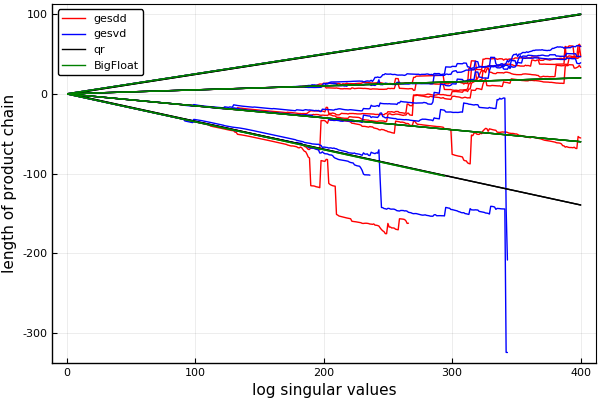

In [447]:
using Plots; pyplot();
default(framestyle = :box, legend = true)

Plots.plot(svs_mygesdd, color=:red, labels = reshape(["gesdd", "", "","", "","", "", ""], (1,8)))
Plots.plot!(svs_mygesvd, color=:blue, labels = reshape(["gesvd", "", "","", "","", "", ""], (1,8)))
Plots.plot!(svs_myqr, color=:black, labels = reshape(["qr", "", "","", "","", "", ""], (1,8)))
Plots.plot!(svs_mygenericsvd, color=:green, labels = reshape(["BigFloat", "", "","", "","", "", ""], (1,8)))
xlabel!("log singular values")
ylabel!("length of product chain")
# ylims!(-250, 200)